In [1]:
import os
import sys
import pandas as pd
import numpy as np
import argparse
import datetime
import time
from sklearn import metrics
from collections import defaultdict
import torch
import torch.nn as nn
from torch import nn, Tensor
from typing import List
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchsummary import summary
from utils.dataset import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# read data
pairs = 5000
pairdata, freqpairs, n_size, n_interval = get_fb_data(pairs)
sizedata = get_data(pairdata, freqpairs, 'size_index', n_size)

In [10]:
seq_set = defaultdict(list)
target_set = defaultdict(list)
size_set = {}

for pair in range(pairs):
    size_index = pairdata[freqpairs[pair]].size_index.values
    target_index = np.concatenate((size_index[1:], size_index[0:1]))
    for i in range(len(size_index) - 16):
        seq_set[pair].append(size_index[i:i+16])
        target_set[pair].append(target_index[i:i+16])
        size_set[pair] = sizedata[pair]
    seq_set[pair] = np.array(seq_set[pair])
    target_set[pair] = np.array(target_set[pair])

In [11]:
def sample_dataset(seed):
    np.random.seed(seed)
    dataset = []
    for pair in range(pairs):
        ran_index = np.random.randint(len(seq_set[pair]))
        dataset.append([seq_set[pair][ran_index], size_set[pair], target_set[pair][ran_index]])
    return dataset

def inputTensor(lines):
    tensor = torch.zeros(lines.shape[1], lines.shape[0], n_size, dtype=torch.long)
    for line in range(lines.shape[0]):
        for i in range(lines.shape[1]):
            size = lines[line][i]
            tensor[i][line][size] = 1
    return tensor

dataset = sample_dataset(0)
dataloader = DataLoader(dataset[:32], batch_size=32, shuffle=False)

In [12]:
class SizeToHidden(nn.Module):
    def __init__(self, input_size, hidden_dims, hidden_size, n_layer):
        super(SizeToHidden, self).__init__()
        self.lins = nn.ModuleList()
        self.n_layer = n_layer
        self.hidden_size = hidden_size
        in_dim = input_size 
        for h_dim in hidden_dims:
            self.lins.append(
                nn.Sequential(
                    nn.Linear(in_dim, out_features=h_dim),
                    nn.ReLU())
            )
            in_dim = h_dim
        self.output = nn.Linear(in_dim, out_features=hidden_size * n_layer)

    def forward(self, x: Tensor) -> List[Tensor]:
        for lin in self.lins:
            x = lin(x)
        x = self.output(x)
        x = x.view(-1, self.n_layer, self.hidden_size)
        x = x.permute(1, 0, 2).contiguous()
        return x

In [13]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, n_layer):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, n_layer)
        self.h2o = nn.Linear(hidden_size, n_size)
        self.softmax = nn.LogSoftmax(dim=2)
    
    def forward(self, x, hidden):
        out, hidden = self.gru(x, hidden)
        out = self.h2o(out)
        out = self.softmax(out)
        return out, hidden

In [14]:
hidden_size = 2048
gru = GRU(n_size, hidden_size, 1).to(device)
s2h = SizeToHidden(n_size, [64, 128, 256, 512], hidden_size, 1).to(device)

In [15]:
seq_tensor, size_tensor, target_tensor = next(iter(dataloader))
seq_tensor = inputTensor(seq_tensor).float().to(device)
size_tensor = size_tensor.float().to(device)
target_tensor = target_tensor.T.long().to(device)

In [16]:
def train(dataloader, optimizer):
    gru.train()
    s2h.train()
    sum_loss = 0
    for seq_tensor, size_tensor, target_tensor in dataloader:
        seq_tensor = inputTensor(seq_tensor).float().to(device)
        size_tensor = size_tensor.float().to(device)
        target_tensor = target_tensor.T.long().to(device)
        optimizer.zero_grad()
        output, hn = gru(seq_tensor, s2h(size_tensor))
        loss = 0
        for i in range(16):
            loss += nn.NLLLoss()(output[i], target_tensor[i])
        loss.backward()
        optimizer.step()
        sum_loss += loss.item() / seq_tensor.shape[0] * seq_tensor.shape[1]
    return sum_loss / len(dataloader.dataset)

In [17]:
lr = 1e-3
optimizer = torch.optim.Adam([{'params': gru.parameters()}, {'params': s2h.parameters()}], lr=lr)

s_time = time.time()
plot_every = 100
avg_loss = 0
for i in range(1000001):
    dataset = sample_dataset(i)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
    loss = train(dataloader, optimizer)
    avg_loss += loss
    if i and i % plot_every == 0:
        print(i, loss, avg_loss / plot_every, time.time() - s_time)
        if avg_loss / plot_every < 0.25:
            print(i, avg_loss / plot_every)
            break
        avg_loss = 0

100 2.3160696449279787 2.35368677686882 113.86899447441101
200 2.3131898071289063 2.3141624546356203 227.1769917011261
300 2.306997721862793 2.3112720739593504 340.25801157951355
400 2.311916107940674 2.3101098467597962 462.07182002067566
500 2.308249969482422 2.306457418380738 582.9458944797516
600 2.271333186340332 2.2940817461814884 690.6313438415527
700 2.2087555171966553 2.24640653975296 799.6279299259186
800 2.1193180435180663 2.165585522846222 904.4874849319458
900 2.036009008216858 2.0784407346343996 1015.1102910041809
1000 1.94788709564209 1.995930015504837 1124.394581079483
1100 1.886053014945984 1.9235627049694062 1235.484705209732
1200 1.8269884773254395 1.8591957356719968 1351.2563254833221
1300 1.7774220674514771 1.799531401294708 1464.4083783626556
1400 1.7216229806900025 1.748772348670959 1575.8642156124115
1500 1.6730881719589232 1.7018323226566308 1689.0793414115906
1600 1.634961676979065 1.6605244499549867 1808.0645728111267
1700 1.602333342552185 1.621310037485123 1

In [109]:
softmax = nn.Softmax(dim=2).to(device)
def sample(size_data, seq_length, start_size=8):
    gru.eval()
    s2h.eval()
    with torch.no_grad():  # no need to track history in sampling
        size_tensor = torch.tensor(size_data, dtype=torch.float).to(device)
        hn = s2h(size_tensor)
        output_seq = [start_size]
        size = start_size
        for _ in range(seq_length - 1):
            input = inputTensor(np.array([[size]])).to(device)
            input = input.float()
            output, hn = gru(input, hn)
            output = softmax(output)
            p_size = output.detach().cpu().numpy().squeeze()
            size = np.random.choice(n_size, p=p_size)
            output_seq.append(size)
        return output_seq

def is_subarray(arr1, arr2):
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    for i in range(len(arr1) - len(arr2) + 1):
        if np.array_equal(arr1[i:i+len(arr2)], arr2):
            return True
    return False

In [110]:
pair = 0
start_size = 8
for i in range(100):
    size_index = np.concatenate((pairdata[freqpairs[pair]].size_index.values, pairdata[freqpairs[pair]].size_index.values[0:1]))
    a = sample(sizedata[pair], 16, start_size)
    print(a, is_subarray(size_index, a))

[8, 11, 13, 4, 13, 6, 13, 7, 13, 6, 7, 7, 4, 11, 8, 4] True
[8, 4, 8, 11, 8, 13, 4, 7, 16, 13, 7, 6, 7, 3, 7, 11] True
[8, 4, 8, 11, 8, 13, 4, 7, 16, 13, 7, 6, 7, 3, 7, 11] True
[8, 7, 9, 8, 8, 4, 13, 4, 8, 11, 13, 4, 13, 6, 13, 7] True
[8, 13, 7, 13, 13, 7, 7, 4, 4, 6, 13, 6, 4, 6, 11, 4] False
[8, 7, 8, 8, 7, 9, 8, 8, 4, 13, 4, 8, 11, 13, 4, 13] True
[8, 7, 4, 7, 4, 15, 4, 11, 4, 4, 11, 4, 4, 11, 4, 4] False
[8, 6, 6, 11, 8, 8, 8, 11, 7, 7, 11, 11, 8, 8, 6, 7] True
[8, 8, 4, 8, 11, 8, 13, 4, 7, 16, 13, 7, 6, 7, 3, 7] True
[8, 4, 9, 11, 4, 4, 11, 4, 4, 13, 4, 7, 8, 6, 10, 7] True
[8, 8, 6, 7, 13, 7, 13, 15, 5, 8, 4, 13, 8, 4, 13, 1] True
[8, 8, 7, 11, 7, 4, 15, 4, 10, 4, 11, 6, 8, 6, 4, 13] True
[8, 11, 11, 13, 10, 7, 11, 4, 9, 13, 8, 8, 8, 11, 7, 11] False
[8, 6, 4, 13, 9, 4, 4, 10, 8, 7, 8, 8, 7, 9, 8, 8] True
[8, 4, 11, 2, 4, 8, 6, 6, 11, 8, 8, 8, 11, 7, 7, 11] True
[8, 13, 4, 7, 16, 13, 7, 6, 7, 3, 7, 11, 10, 4, 10, 4] True
[8, 11, 13, 4, 13, 6, 13, 7, 13, 6, 7, 7, 4, 11, 8, 4] Tr

In [111]:
from scipy.stats import entropy
def JSD(p, q):
    p = list(p)
    q = list(q)
    pq_max_len = max(len(p), len(q))
    p += [0.0] * (pq_max_len - len(p))
    q += [0.0] * (pq_max_len - len(q))
    assert (len(p) == len(q))
    m = np.sum([p, q], axis=0) / 2
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

s2s_pair, size_trans = get_trans(pairdata, freqpairs, 'size_index', n_size)

In [112]:
rnn_jsds, he_jsds = [], []
for pair in range(1000):
    size_data = sizedata[pair]
    size_index = np.concatenate((pairdata[freqpairs[pair]].size_index.values, pairdata[freqpairs[pair]].size_index.values[0:1]))

    for seed in range(100):
        np.random.seed(seed)
        torch.manual_seed(seed)
        start_size = np.random.choice(np.arange(30), p=sizedata[pair])
        size_seq_gen = [start_size]
        while len(size_seq_gen) < 1000:
            new_size = sample(size_data, 16, start_size=start_size)
            if set(new_size).issubset(np.unique(pairdata[freqpairs[pair]].size_index.values)):
                size_seq_gen += list(new_size[1:])
                start_size = new_size[-1]
                if seed > 10:
                    start_size = np.random.choice(np.arange(30), p=sizedata[pair])
        size_seq_gen = np.array(size_seq_gen)
        values, counts = np.unique(size_seq_gen, return_counts=True)
        new_size = np.zeros(n_size, dtype=float)
        new_size[values] = counts
        new_size /= new_size.sum()

        rnn_s2s_pair = [size_seq_gen[:-1] * n_size + size_seq_gen[1:]]  
        values, counts = np.unique(rnn_s2s_pair, return_counts=True)
        rnn_s2s_pair = np.zeros(n_size ** 2, dtype=float)
        rnn_s2s_pair[values] = counts
        rnn_s2s_pair /= rnn_s2s_pair.sum()
        
        # print(seed, JSD(new_size, sizedata[pair]), JSD(rnn_s2s_pair, s2s_pair[pair]))
        if JSD(new_size, sizedata[pair]) < 0.05:
            break

    rnn_s2s_pair = [size_seq_gen[:-1] * n_size + size_seq_gen[1:]]  
    values, counts = np.unique(rnn_s2s_pair, return_counts=True)
    rnn_s2s_pair = np.zeros(n_size ** 2, dtype=float)
    rnn_s2s_pair[values] = counts
    rnn_s2s_pair /= rnn_s2s_pair.sum()

    he_size_seq = []
    while len(he_size_seq) < 1000:
        size = np.random.choice(np.arange(30), p=sizedata[pair])
        he_size_seq.append(size)
    he_size_seq = np.array(he_size_seq)

    he_s2s_pair = [he_size_seq[:-1] * n_size + he_size_seq[1:]]  
    values, counts = np.unique(he_s2s_pair, return_counts=True)
    he_s2s_pair = np.zeros(n_size * n_size, dtype=float)
    he_s2s_pair[values] = counts
    he_s2s_pair /= he_s2s_pair.sum()

    print(pair, JSD(new_size, sizedata[pair]), JSD(rnn_s2s_pair, s2s_pair[pair]), JSD(he_s2s_pair, s2s_pair[pair]))
    rnn_jsds.append(JSD(rnn_s2s_pair, s2s_pair[pair]))
    he_jsds.append(JSD(he_s2s_pair, s2s_pair[pair]))

0 0.003089426112005511 0.012783106823849297 0.0736751094920089
1 0.003805099860268231 0.03423671208684009 0.09587070479026971
2 0.007313000656775247 0.036493810404516186 0.09041966129037701
3 0.003953102474253482 0.027912572641804596 0.08008451724201542
4 0.0028121762029000488 0.04265868426025503 0.11541280624370863
5 0.028093310140719724 0.045655364779644894 0.050888281656071496
6 0.004715471292789084 0.051702615172226865 0.12974426772181177
7 0.003286229237808734 0.04365951351503524 0.11718434610348075
8 0.004814502420858707 0.04794185095657805 0.13076504713529877
9 0.0019614642952987156 0.028712510543051226 0.09984615243879238
10 0.004400147327466313 0.03086124641722484 0.09492980652937826
11 0.002919070456050784 0.03718577556145419 0.12444833584924142
12 0.0036458407885973827 0.026631140867364386 0.11170162928225534
13 0.006416867393995086 0.04281326354554425 0.1098784278877494
14 0.0032983226542303737 0.03146831704311686 0.09928859705597556
15 0.001967341257824971 0.03287745958453

(0.0, 1.05)

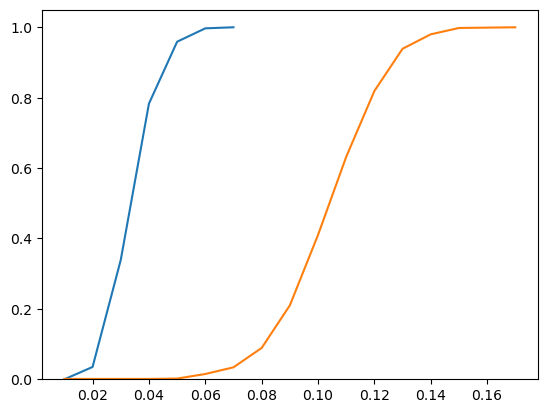

In [113]:
import matplotlib.pyplot as plt

values, bins = np.histogram(rnn_jsds, bins=np.arange(0, np.max(rnn_jsds) + 0.01, 0.01))
cdf = np.cumsum(values) / np.sum(values)
plt.plot(bins[1:], cdf)

values, bins = np.histogram(he_jsds, bins=np.arange(0, np.max(he_jsds) + 0.01, 0.01))
cdf = np.cumsum(values) / np.sum(values)
plt.plot(bins[1:], cdf)

plt.ylim(0, 1.05)

In [41]:
for i in [50, 90, 95, 99]:
    print(i, np.percentile(rnn_jsds, i), np.percentile(he_jsds, i))

50 0.016796066997483282 0.07346432855368562
90 0.07909204873483928 0.2751986895385197
95 0.09532450370252392 0.31491465589104833
99 0.1320168295307611 0.3700949495105308


In [136]:
for i in [50, 90, 95, 99]:
    print(i, np.percentile(rnn_jsds, i), np.percentile(he_jsds, i))

50 0.012160265192768834 0.07145898533012404
90 0.047915725836543216 0.2727736298325866
95 0.053717750535610495 0.3153216864822403
99 0.06597230544940674 0.36794891171362076


In [10]:
# torch.save(gru, 'models/gru-0504.pth')
# torch.save(s2h, 'models/s2h-0504.pth')

In [11]:
class SizeDecoder(torch.nn.Module):
    def __init__(self, output_dim, hidden_dims, latent_dim):
        super(SizeDecoder, self).__init__()
        self.decoder = torch.nn.ModuleList()
        in_dim = latent_dim
        for h_dim in hidden_dims:
            self.decoder.append(
                nn.Sequential(
                    nn.Linear(in_dim, out_features=h_dim,),
                    nn.ReLU())
            )
            in_dim = h_dim
        self.output = nn.Linear(hidden_dims[-1], output_dim)
    
    def forward(self, x: Tensor) -> List[Tensor]:
        for module in self.decoder:
            x = module(x)
        result = self.output(x)
        result = F.softmax(result, dim=1)
        return result
    
decoder = torch.load('models/size-decoder-0425.pth')
gru = torch.load('models/gru-0504.pth')
s2h = torch.load('models/s2h-0504.pth')

In [50]:
from scipy.stats import entropy
from tqdm import tqdm
def JSD(p, q):
    p = list(p)
    q = list(q)
    pq_max_len = max(len(p), len(q))
    p += [0.0] * (pq_max_len - len(p))
    q += [0.0] * (pq_max_len - len(q))
    assert (len(p) == len(q))
    m = np.sum([p, q], axis=0) / 2
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

def sample_noisy_dataset(n, seed):
    torch.manual_seed(seed)
    dataset = []
    for i in tqdm(range(n)):
        latent_dim = 32
        z = torch.randn((1, latent_dim)).to(device)
        size = decoder(z)
        size = size.squeeze().detach().to('cpu').numpy()
        size[size < 1e-3] = 0
        size /= size.sum()

        dis = []
        for j in range(1000):
            loss = JSD(size, sizedata[j])
            dis.append(loss)

        pair = np.argmin(dis)
        ran_index = np.random.randint(len(seq_set[pair]))
        dataset.append([seq_set[pair][ran_index], size, target_set[pair][ran_index]])
        
    return dataset

In [71]:
a = []
for i in tqdm(range(1000)):
    torch.manual_seed(i)
    latent_dim = 32
    z = torch.randn((1, latent_dim)).to(device)
    size = decoder(z)
    size = size.squeeze().detach().to('cpu').numpy()
    size[size < 1e-3] = 0
    size /= size.sum()

    dis = []
    for j in range(1000):
        loss = JSD(size, sizedata[j])
        dis.append(loss)

    pair = np.argmin(dis)
    a.append(pair)

100%|██████████| 5000/5000 [05:13<00:00, 15.93it/s]


In [47]:
lr = 1e-3
# optimizer = torch.optim.Adam([{'params': s2h.parameters()}], lr=lr)
optimizer = torch.optim.Adam([{'params': gru.parameters()}, {'params': s2h.parameters()}], lr=lr)

s_time = time.time()
plot_every = 100
avg_loss = 0
for i in range(1000001):
    dataset = sample_dataset(i)
    ran_index = np.random.permutation(len(tune_dataset))[0:1000]
    # dataset.extend([tune_dataset[i] for i in ran_index])
    dataloader = DataLoader(dataset, batch_size=2000, shuffle=True)
    loss = train(dataloader, optimizer)
    avg_loss += loss
    if i and i % plot_every == 0:
        print(i, loss, avg_loss / plot_every, time.time() - s_time)
        if avg_loss / plot_every < 0.1:
            print(i, avg_loss / plot_every)
            break
        avg_loss = 0

100 0.37469881772994995 0.36950908958911893 11.19027829170227
200 0.36915746331214905 0.35975850641727447 21.188878059387207
300 0.35969191789627075 0.35673402369022367 32.09577918052673


KeyboardInterrupt: 

In [74]:
from tqdm import tqdm
a = set()
for i in tqdm(range(1000)):
    torch.manual_seed(i)
    latent_dim = 32
    z = torch.randn((1, latent_dim)).to(device)
    size = decoder(z)
    size = size.squeeze().detach().to('cpu').numpy()
    size[size < 1e-3] = 0
    size /= size.sum()

    dis = []
    for j in range(1000):
        loss = JSD(size, sizedata[j])
        dis.append(loss)
        # if loss < 0.02:
        #     a.add(j)

    pair = np.argmin(dis)
    a.add(pair)

100%|██████████| 1000/1000 [00:58<00:00, 17.09it/s]


In [73]:
jsds = np.zeros((1000, 1000))
for i in range(1000):
    for j in range(1000):
        jsds[i][j] = JSD(sizedata[i], sizedata[j])

In [75]:
np.sort(jsds[8])

array([0.        , 0.0712686 , 0.0989841 , 0.10461984, 0.10732551,
       0.11061315, 0.11413909, 0.11538036, 0.11660952, 0.11782312,
       0.12270552, 0.12357579, 0.12381709, 0.12831985, 0.12900488,
       0.13021052, 0.13290488, 0.13328528, 0.13464494, 0.13588953,
       0.13698097, 0.13924533, 0.14027519, 0.14082266, 0.14095486,
       0.14102039, 0.14222849, 0.14290341, 0.14387662, 0.14660579,
       0.14678407, 0.14694698, 0.14717077, 0.14719107, 0.14890525,
       0.14939437, 0.14958512, 0.15188435, 0.1524103 , 0.15251156,
       0.15369764, 0.1559504 , 0.15639397, 0.15688702, 0.15898742,
       0.15899087, 0.16149691, 0.16396171, 0.16474164, 0.16477304,
       0.1657369 , 0.16581361, 0.16621777, 0.16631866, 0.1666306 ,
       0.16702055, 0.16783559, 0.16789516, 0.16937711, 0.16999767,
       0.17006917, 0.17089419, 0.17237322, 0.17269899, 0.17295262,
       0.17311279, 0.1738042 , 0.17434601, 0.17441435, 0.17492409,
       0.17498089, 0.17590966, 0.17673751, 0.1767769 , 0.17685

In [65]:
(jsds < 0.01).sum(axis=1)

array([  2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   3,   1,   1,  95,   1,   1,   1,   1,   1,   2,   1,  96,
         1,   1,   1,   4,   1,   2,   1,   1,   1,   1,   2,   1,   3,
         1,   1,   1,   2,   3,   1,   1,   2,   4,   2,   1,   1,   1,
         2,   1,   2,   1,   1,   1,   1,   1,   1,   1,   4,   3,   1,
         3,   1,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   3,
         1,   1,   6,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   3,   1,   1,   1,   1,   1,   1,   6,
         2,   1,   1,   4,   1,   2,   1,   1,   1,   1,   1,   1,   4,
         1,   1,   1,   1,   1,   1,   1,  76,   2,   1,   1,  29,   1,
         1,   4,   5,   1,   1,   1,   1,   1,   2,   1,   1,   5,   7,
         4,   1,   2,   1,   5,   1,   4,   1,   1,   1,   1,  20,   7,
         5,   1,   1,   1,   1,   1,   1,   1,   5,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   4,   2,   1,   1,   1,   1,   